In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [2]:
test_run = 1

In [3]:
class Model(nn.Module):
    def __init__(self, input_num: int, layers: list[int], dropout_p: float = 0.5):
        super(Model, self).__init__()

        layers_list = []

        in_num = input_num
        for i in layers:
            layers_list.append(nn.Linear(in_num, i))
            layers_list.append(nn.ReLU(inplace=True))
            layers_list.append(nn.BatchNorm1d(i))
            layers_list.append(nn.Dropout(dropout_p))
            in_num = i

        layers_list.append(nn.Linear(layers[-1], 1))
        self.layers = nn.Sequential(*layers_list)

    def forward(self, x):
        x = self.layers(x)
        return x

In [4]:
data = pd.read_csv('House_Rent_Dataset.csv')

In [5]:
data.drop(columns='Area Locality', inplace=True)
data.drop(columns='Posted On', inplace=True)
data["Total Floors"] = data["Floor"].apply(lambda floor: floor.split()[-1]).replace('Ground', 1)
data["Floor"] = (data["Floor"].apply(lambda floor: floor.split()[0])
                     .replace('Ground', 0)
                     .replace('Upper', 99)
                     .replace('Lower', -1)).astype("int64")

data = pd.get_dummies(data, columns=['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of '
                                                                                                       'Contact'])

In [6]:
X = data.drop(columns='Rent', axis=1).astype("float")
y = data['Rent'].astype("float")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=77)

X_train = torch.FloatTensor(X_train.to_numpy())
X_val = torch.FloatTensor(X_val.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy()).reshape(-1,1)
y_test = torch.FloatTensor(y_test.to_numpy()).reshape(-1,1)
y_val = torch.FloatTensor(y_val.to_numpy()).reshape(-1,1)

In [31]:
torch.manual_seed(77)
model = Model(X.shape[1], [400, 200, 100], 0.4)

In [32]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [33]:
epochs = 800
losses = []
start_time = time.time()
for i in range(epochs):
    i += 1
    y_pred = model.forward(X_train)
    #loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss.item())
    
    if i % 10 == 1:
        print(f"Epoch ({i:3}): Loss: {loss.item():10.5f}")
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Final loss after {epochs} epochs: {losses[-1]:8.5f}")
print(f"Duration: {time.time() - start_time:.2f} seconds")

Epoch (  1): Loss:   -0.00000


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Text(0.5, 0, 'epoch')

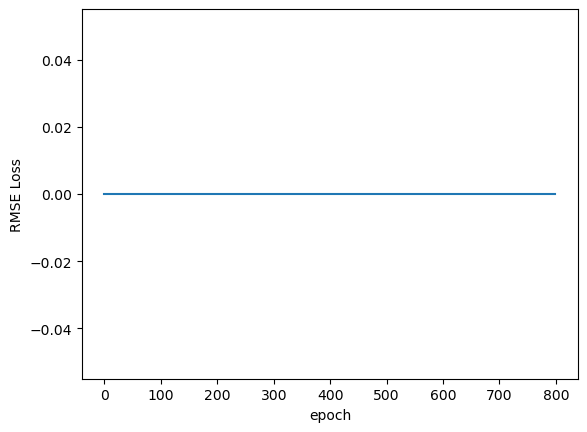

In [27]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [27]:
criterion = nn.L1Loss()
with torch.no_grad():
    y_pred = model(X_val)
    loss = torch.sqrt(criterion(y_pred, y_val))
    print(f"Validation loss after {epochs} epochs: {loss.item():8.5f}")

Validation loss after 800 epochs: 142.41216
